# todo

* get the fitting function from paula to work
* update Spin Phonon H for red sideband and carrier
* check everything on new computer
* do the double quench minimum search again, with multiprocessing

# Import stuff, set default parameters

In [1]:
%load_ext autoreload
%autoreload 2

# import python stuff
import matplotlib.pyplot as plt
import numpy as np
# import qutip
import scipy
import scipy.special as spe
from scipy import optimize
from qutip import *
import time
import multiprocessing as mp
from platform import python_version
from iminuit import Minuit

# import my functions
from functionsSqueeze import *
from functions_SpinPhonon import *

# import existing Paula funcitons
from PyModules.analyse_eios import eios_sb

print("python version:", python_version())
print("number of CPU's:", mp.cpu_count())

python version: 3.6.9
number of CPU's: 8


Units: time in $\mu s$ and circular frequency in MHz<br/>
    $\hbar$ is set to 1 => the hamiltonian has unit MHz

In [2]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQQ = np.linspace(-1, 3.5, 351)
argsQQ = {'n': n,
         'omega': wQQ,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': -0.8*w0,
         'dt2': 0.18,
         'delay': 2*T+1.8098867063776491,
         'f0': 100/(9)}

timesQ = np.linspace(-1, 1, 200)
argsQ = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': -0.8*w0,
         'dtQ': 0.18,
         'dwP': 0,
         'dtP': 0,
         'delay': 0,
         'f0': 100/(9)}

timesP = np.linspace(-0.1,1, 300)
argsP = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 0.3*w0,
         'dtP': 8*np.pi/(2*w0),
         'delay': 0,
         'f0': 0.002/(9)}

timesNix = np.linspace(-0, 2, 100)
argsNix = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 0,
         'dtP': 0,
         'delay': 0,
         'f0': 100/(9)}

timesQP = np.linspace(-0.8,1, 900)
argsQP = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': -0.5*w0,
         'dtQ': 0.18,
         'dwP': 0.3*w0,
         'dtP': 4*np.pi/(2*w0),
         'delay': 0.3,
         'f0': 0.002/(9)}

# Do some things to optimize processing time

## do another time evolution routine

In this section, I try a new routine (via c or c++, using mesolve with the string format) to calculate the time evolution.<br/>
It turns out that it is much faster (approx 3-20x).

In [3]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz

timesQQ = np.linspace(-1, 3.5, 451)
timesQQ = np.linspace(-1, 1, 200)

argsC = {'n': n,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': 0,
         'dt2': 0.18,
         'delay': 2*T+1.8098867063776491,
         'f0': 100/(9)}

argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.8*w0, 0.18, 0, 0.18, 2*T+1.8098867063776491],
       'f0': 100/(9)}

In [5]:
# comparison with the "standard" method
t1 = time.time()
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)
print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 7.63 s


In [41]:
# this cell shows how the string format method works

# ad = create(n)
# a = destroy(n)

# strWQQ = '(w0 + dw1*exp(-0.5*(t/dt1)**2) + dw2*exp(-0.5*((t-delay)/dt2)**2))'
# strDWQQ = '((- dw1*exp(-0.5*(t/dt1)**2)*t/(dt1**2)) - (dw2*exp(-0.5*((t-delay)/dt2)**2)*(t-delay)/(dt2**2)))'

# Hc = [[(ad*a+0.5*qeye(n)), strWQQ],
#       [(a*a-ad*ad), '1j/4*(' + strDWQQ + ')/(' + strWQQ + ')'],
#       [(ad+a), '9*((f0/(' + strWQQ + ')**2) - (f0/(w0**2)))']]

# resultsC = mesolve(Hc, psi0, timesQQ, args = argsC)

In [6]:
# have a look at the optins class
opt = Options()
# opt.nsteps = 200
# opt.rhs_reuse = True
print(opt)

Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          8
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False



In [7]:
t1 = time.time()
# opt = Options()
# opt.rhs_reuse = True # if this is true, the compiled code will be reused
                     # => first time calculation: no difference, after that much faster 

resultsC = eval_H_QQ(psi0, timesQQ, argsC, options=opt)
print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 3.08 s


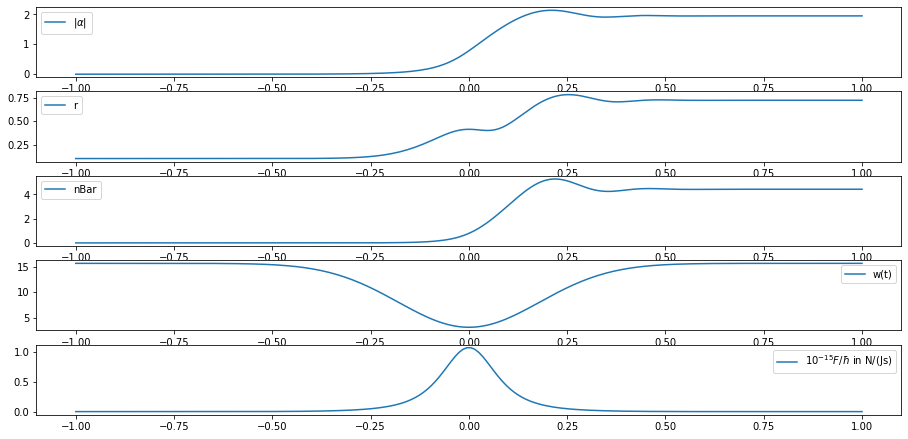

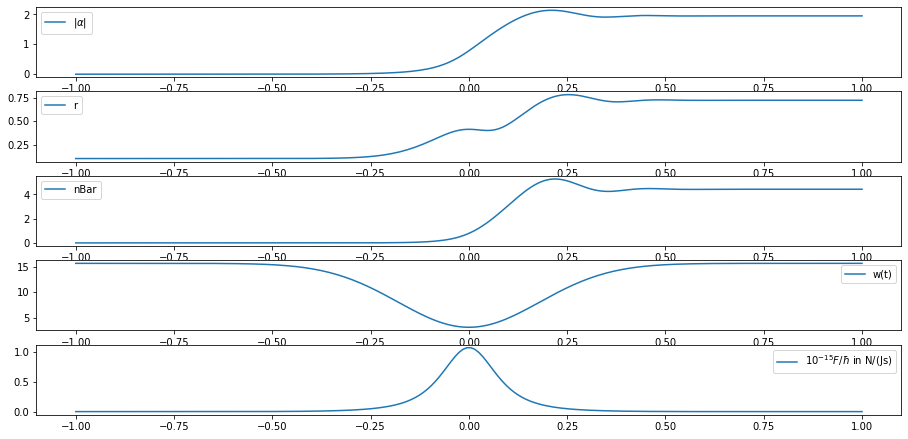

0

In [8]:
# compare both routines
plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = False)
plotResults(timesQQ, resultsC, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = False)

## check how many time steps are needed

In [9]:
# consider only one quench
argsC = {'n': n,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': 0,
         'dt2': 0.18,
         'delay': 2*T+1.8098867063776491,
         'f0': 100/(9)}

In [10]:
t1 = time.time()
opt = Options()
opt.rhs_reuse = True

stepsList = np.linspace(5, 100, 20) # steps per mu s
resList = []

for n_steps in stepsList:
    timesQ = np.linspace(-1, 1, int(2*n_steps + 1))
    t2 = time.time()
    resultQ = eval_H_QQ(fock_dm(n), timesQ, argsC, options = opt)
#     resultQ = mesolve(H, fock_dm(n), timesQ, args=argsQ)
    alpha, xi, nBar, nT = getParams(resultQ.states[-1], calculate_nT = False)
    t22 = time.time() - t2
    resList.append([alpha, xi, nBar, t22])

print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 11.84 s


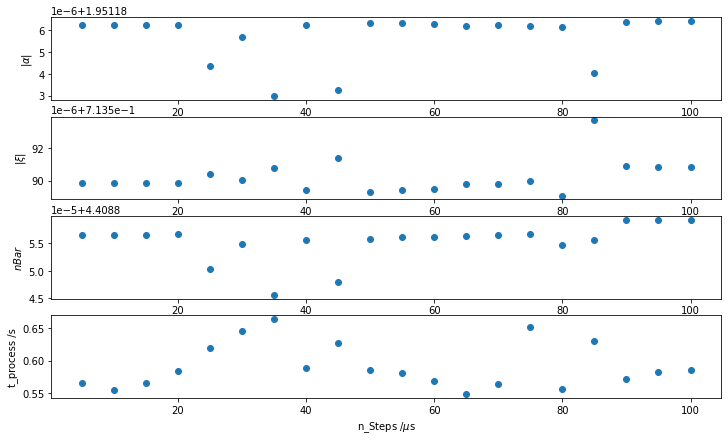

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 7, forward=True)
ax1.scatter(stepsList, [np.abs(a[0]) for a in resList])
ax1.set_ylabel(r'$|\alpha|$')
ax2.scatter(stepsList, [np.abs(a[1]) for a in resList])
ax2.set_ylabel(r'$|\xi|$')
ax3.scatter(stepsList, [a[2] for a in resList])
ax3.set_ylabel(r'$nBar$')
ax4.scatter(stepsList, [a[3] for a in resList])
ax4.set_ylabel(r't_process /s')
ax4.set_xlabel(r'n_Steps /$\mu$s')
plt.show()

Variation of the final state for different dense lists of times given to the time evolution calculator.<br/>
Since the differences in the states are very small (check the axis scale!), the times list has no (or very little) effect on the numerical accuracy

In [12]:
t1 = time.time()
stepsList = np.linspace(50, 1000, 20) # steps per mu s
resList = []
opt = Options()
opt.rhs_reuse = True

timesQ = np.linspace(-1, 1, 101)
for n_steps in stepsList:
    opt.nsteps = n_steps
    t2 = time.time()
    resultQ = eval_H_QQ(fock_dm(n), timesQ, argsC, options = opt)
#     resultQ = mesolve(H, fock_dm(n), timesQ, args=argsQ, options=opt)
    alpha, xi, nBar, nT = getParams(resultQ.states[-1], calculate_nT = False)
    t22 = time.time() - t2
    resList.append([alpha, xi, nBar, t22])
    print("n_steps:", n_steps, "processing time:", round(100*t22)/100, "s")

print("processing time:", round(100*(time.time()-t1))/100, "s")

n_steps: 50.0 processing time: 0.59 s
n_steps: 100.0 processing time: 0.58 s
n_steps: 150.0 processing time: 0.58 s
n_steps: 200.0 processing time: 0.58 s
n_steps: 250.0 processing time: 0.58 s
n_steps: 300.0 processing time: 0.58 s
n_steps: 350.0 processing time: 0.59 s
n_steps: 400.0 processing time: 0.58 s
n_steps: 450.0 processing time: 0.58 s
n_steps: 500.0 processing time: 0.58 s
n_steps: 550.0 processing time: 0.58 s
n_steps: 600.0 processing time: 0.58 s
n_steps: 650.0 processing time: 0.59 s
n_steps: 700.0 processing time: 0.59 s
n_steps: 750.0 processing time: 0.58 s
n_steps: 800.0 processing time: 0.58 s
n_steps: 850.0 processing time: 0.58 s
n_steps: 900.0 processing time: 0.58 s
n_steps: 950.0 processing time: 0.58 s
n_steps: 1000.0 processing time: 0.58 s
processing time: 11.65 s


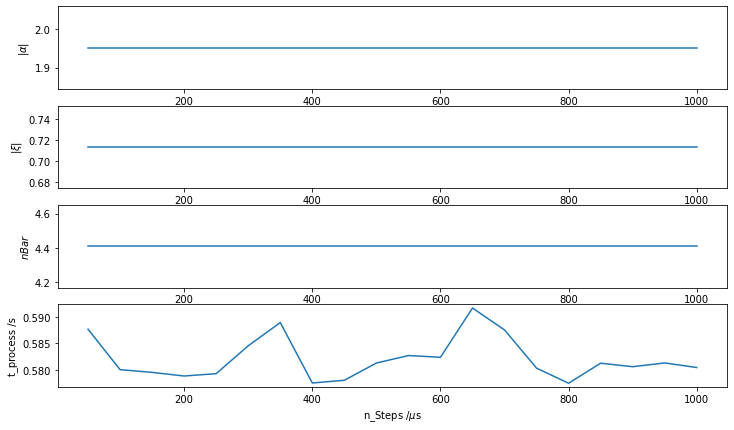

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 7, forward=True)
ax1.plot(stepsList, [np.abs(a[0]) for a in resList])
ax1.set_ylabel(r'$|\alpha|$')
ax2.plot(stepsList, [np.abs(a[1]) for a in resList])
ax2.set_ylabel(r'$|\xi|$')
ax3.plot(stepsList, [a[2] for a in resList])
ax3.set_ylabel(r'$nBar$')
ax4.plot(stepsList, [a[3] for a in resList])
ax4.set_ylabel(r't_process /s')
ax4.set_xlabel(r'n_Steps /$\mu$s')
plt.show()

Variation of the final state for different dense lists of times given to the time evolution calculator.<br/>
Since the differences in the states are very small (check the axis scale!), the times list has no (or very little) effect on the numerical accuracy

# run the time evolution for one set of parameters above

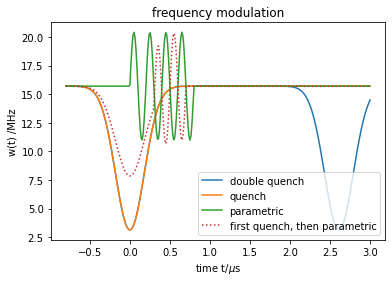

In [3]:
# plot different frequency modulations, to check that they are what I want them to be
tlist = np.linspace(-0.8,3,300)

wQuench2 = wQQ(tlist, argsQQ)
wQuench = wQP(tlist, argsQ)
wParam = wQP(tlist, argsP)
wBoth = wQP(tlist, argsQP)

plt.plot(tlist, wQuench2, label="double quench")
plt.plot(tlist, wQuench, label="quench")
plt.plot(tlist, wParam, label="parametric")
plt.plot(tlist, wBoth,":", label="first quench, then parametric")
plt.legend()
plt.title("frequency modulation")
plt.xlabel(r'time t/$\mu$s')
plt.ylabel(r'w(t) /MHz')
plt.show()

In [4]:
opt = Options()
opt.rhs_reuse = True

t1 = time.time()
resultQQ = eval_H_QQ(psi0, timesQQ, argsQQ)
resultQ = eval_H_QP(psi0, timesQ, argsQ)
resultP = eval_H_QP(psi0, timesP, argsP, options=opt)
resultQP = eval_H_QP(psi0, timesQP, argsQP, options=opt)
resultNix = eval_H_QP(psi0, timesNix, argsNix, options=opt)

print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 8.58 s


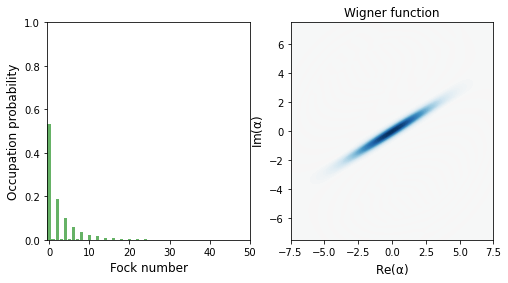

processing time: 0.95 s


In [5]:
t1 = time.time()
result = resultQQ
psi = result.states[-1]

plot_wigner_fock_distribution(psi)
plt.show()
print("processing time:", round(100*(time.time()-t1))/100, "s")

|alpha|= (-0.03640564016235689-0.039056374905720136j) , xi = (-0.6046199695771239-1.0852017588707847j) , nBar = 2.52257631744336 , nT = 0.016882411797245134
xi = 1.2422673484671836 exp(i x -2.079112268779451 )


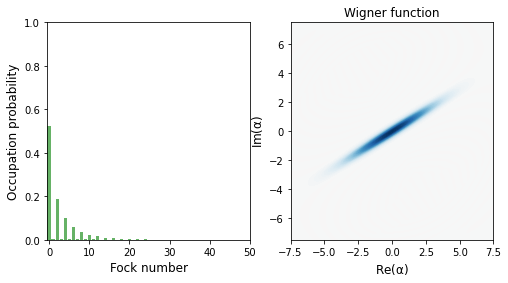

In [6]:
order_SD = False
alpha, xi, nBar, nT = getParams(psi, order_SD = order_SD)
print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)
print('xi =', np.abs(xi), 'exp(i x', np.angle(xi), ')')

# depending on order_SD, the parameters are calculated for S*D or D*S
if order_SD:
    psi1 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, nT)*displace(n, alpha).dag()*squeeze(n, xi).dag()
else:
    psi1 = displace(n, alpha)*squeeze(n, xi)*thermal_dm(n, nT)*squeeze(n, xi).dag()*displace(n, alpha).dag()
    
# plot the wiegner function, should be similar (lokking the same) as above
plot_wigner_fock_distribution(psi1)
plt.show()

Comparison between the original state (above) and the retrieved one (here).<br/>
This checks if the retrieved (above) state is close to the original one (two above), if the angle of the squeezing has wrong sign, you have to calculate nT (which takes by far the most time in the calculation of getParams). Setting order_SD true or false changes the order of the acting of squeezing and displacement.<br/>
In the next plot the time evolutin of various parameters is shown

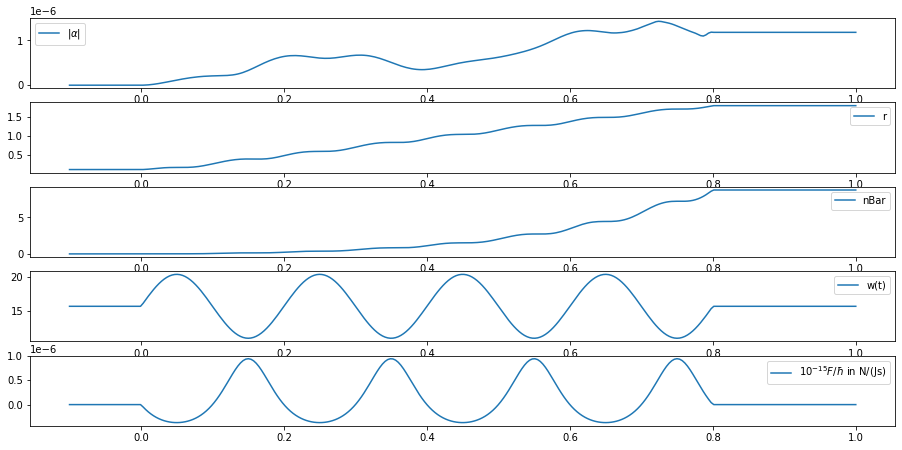

0

In [7]:
plotResults(timesP, resultP, argsP, calculate_nT = False, nSkipp = 1, showProgress = False)

## Reproduction of figure 3 in Lit early universe

In [3]:
timesP = np.linspace(-0.1,50, 1000)
w0p = 2*np.pi*2.8
T = 1/2.8
psi0p = fock_dm(n)
argsP = {'n': n,
         'omega': wQP,
         'w0': w0p,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 2*np.pi * 0.008,
         'dtP': 224 * 2*np.pi/(2*w0p),
         'delay': 0,
         'f0': 0.002/(9)}

In [4]:
t1 = time.time()
opt = Options()
opt.nsteps = 5000

n_steps = 15
dtP_list = []
for i in range(n_steps):
    if i % 2 == 0:
        dtP_list.append(2*2**(i/2) * 2*np.pi/(2*w0p))
    else:
        dtP_list.append(3*2**((i-1)/2) * 2*np.pi/(2*w0p))
        
print("number of periods of the parametric modulation:", np.array(dtP_list)/(2*np.pi/(2*w0p)))

# make a functin that gives the displacement, squeezing and mean phonon number for a given dtP
def get_r_n__dtP(dtP):
    argsP = {'n': n,
     'omega': wQP,
     'w0': w0p,
     'dwQ': 0,
     'dtQ': 0.18,
     'dwP': 2*np.pi * 0.008,
     'dtP': dtP,
     'delay': 0,
     'f0': 0.002/(9)}

    timesP = np.linspace(-0.1, argsP['dtP'] + 2*T, 300)
    
    # do time evolution
    res = eval_H_QP(psi0p, timesP, argsP, options=opt)
    
    # get parameters
    alpha, xi, nBar, nT = getParams(res.states[-1], calculate_nT = False)
    return([argsP['dtP'] * 2*w0p/(2*np.pi), np.abs(alpha), np.abs(xi), nBar])

# calculate the function for different dtP on oll CPUs
if __name__ == "__main__":
    pool = mp.Pool(mp.cpu_count())
    paramsList = pool.map(get_r_n__dtP, dtP_list)
    
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

number of periods of the parametric modulation: [  2.   3.   4.   6.   8.  12.  16.  24.  32.  48.  64.  96. 128. 192.
 256.]
 processing time: 70.19 s


at x=224 (last point in paper):
squeezing parameter r: 1.0053417008433019 and corresponding mean fock number <n>: 1.4005791680173278


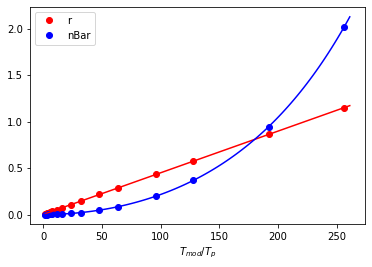

In [5]:
xlist = [a[0] for a in paramsList]
rlist = [a[2] for a in paramsList]
nlist = [a[3] for a in paramsList]
xFkt = np.linspace(xlist[0], xlist[-1]+5, 100)

def fitFktLin(x, a, b):
    return(a*x + b)

params_r, params_r_err = optimize.curve_fit(fitFktLin, xlist, rlist, p0 = [1, 0]) # do the fit for r

rPaper = fitFktLin(224, params_r[0], params_r[1])
print("at x=224 (last point in paper):")
print("squeezing parameter r:", rPaper,"and corresponding mean fock number <n>:", np.sinh(rPaper)**2)

plt.plot(xlist, rlist, 'ro', label=r'r')
plt.plot(xlist, nlist, 'bo', label=r'nBar')
plt.plot(xFkt, [fitFktLin(i, params_r[0], params_r[1]) for i in xFkt], 'r-')
plt.plot(xFkt, [np.sinh(fitFktLin(i, params_r[0], params_r[1]))**2 for i in xFkt], 'b-')
plt.xlabel(r'$T_{mod} / T_p$')
plt.legend()
plt.show()

Squeezing parameter and mean photon number $\bar{n}$ as a function of the modulation time.<br/>
This is a simulation of the experiment shown in Figure 3 in "Lit early universe", with a linear fit for the squeezing parameter $r$. The phonon number between (line) the simulation steps (dots) was calculated using $<n> = \sinh(r)^2$. In comparison to the paper, the simulation for $T_{mod} = 224 T_p$ (final point in the paper) lower squeezing by about 15% (simulation: $r = 1.005$ vs paper: $r = 1.16(5)$), and therefore a lower mean phonon number.

In [6]:
f0List = 10**np.linspace(-5, 1, 7)

def get_f0_r_n(f0):
    argsP = {'n': n,
         'omega': wQP,
         'w0': w0p,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 2*np.pi * 0.008,
         'dtP': 224 * 2*np.pi/(2*w0p),
         'delay': 0,
         'f0': f0}
    timesP = np.linspace(-0.1, argsP['dtP'] + 2*T, 2000)
    
    opt = Options()
    opt.nsteps = 5000
    res = eval_H_QP(psi0p, timesP, argsP, options=opt)
    
    alpha, xi, nBar, nT = getParams(res.states[-1], calculate_nT = False)
    return([f0, np.abs(xi), nBar])

t1 = time.time()
if __name__ == "__main__":
    pool = mp.Pool(mp.cpu_count())
    f0_r_n_list = pool.map(get_f0_r_n, f0List)
    
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 50.17 s


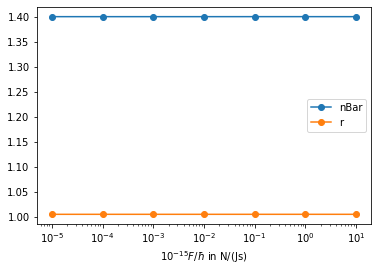

In [7]:
plt.semilogx(f0List, [a[2] for a in f0_r_n_list], 'o-', label=r'nBar')
plt.semilogx(f0List, [a[1] for a in f0_r_n_list], 'o-', label=r'r')
plt.xlabel(r'$10^{-15} F/\hbar$ in N/(Js)')
plt.legend()
plt.show()

Dependance of the squeezing and phonon expectation on the strength of the force.<br/>
Since there is no nependance betrween the squeezing parameter and the strength of the force, a wrong value for the force proportionality constant cannot be the cause of the difference between simulated $r$ value and experimentally observed $r$ value.

# check how $\alpha$ and $\xi$ depend on the pulse shape of a gaussian quench

In [8]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQ = np.linspace(-1, 1, 200)
argsQ = {'n': n,
         'w0': w0,
         'dwQ': -0.8*w0,
         'dtQ': 0.18,
         'dwP': 0,
         'dtP': 0,
         'delay': 0,
         'f0': 100/(9)}

In [9]:
# choose different pulse lengths and see what impact that has on alpha and xi
t1 = time.time()

opt = Options()
opt.rhs_reuse = False

dts = np.linspace(0.04, 0.4, 19, endpoint = False) # from 0.1T to 3T
dts = np.append(dts, np.linspace(0.4, 1.6, 13))
xis = []
alphas = []
for dt in dts:
    argsQ['dtQ'] = dt
    result = eval_H_QP(psi0, timesQ, argsQ, options=opt)
    alpha, xi,_,_ = getParams(result.states[-1], calculate_nT = False)
    
    xis.append(np.abs(xi))
    alphas.append(np.abs(alpha))
    opt.rhs_reuse = True
    print('\r', "Progress:", round(100*(dt-dts[0])/(dts[-1]-dts[0])), "%", end = '')

argsQ['dtQ'] = 0.18    
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 17.63 s


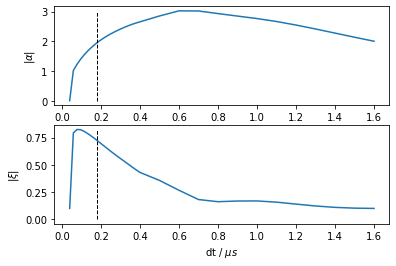

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(dts, alphas)
ax1.plot([0.18, 0.18], [0., max(alphas)], 'k--', linewidth=1)
ax1.set_ylabel(r'$|\alpha|$')
ax2.plot(dts, xis)
ax2.plot([0.18, 0.18], [0., max(xis)], 'k--', linewidth=1)
ax2.set_ylabel(r'$|\xi|$')
ax2.set_xlabel(r'dt / $\mu s$')
plt.show()

coherent displacement and squeezing depending on the pulse duration <br/>
For a gaussian pulse with minimum $\Delta \omega = -0.8 \omega_0$ and pulse durations $dt$ between $0.1 T$ and $2.2 T$ (with $T = 2 \pi/\omega_0$), the coherent displacement $|\alpha |$ and the squeezing $|\xi |$ are calculated. $|\alpha |$ rises monoton and $|\xi |$ has a maximum at very short pulse durations and decreases monotonly for higher $dt$. This shows that a single gaussian pulse is not sufficent to create a squeezed state without coherent displacement. <br/>
The dashed line indicates the pulse length of the pulses taken for further calculations (especially in the investigation of the double pulse sequence)

In [11]:
# check how alpha and xi (both r and t) depend on the pulse strength

t1 = time.time()

opt = Options()
opt.rhs_reuse = False

dws = np.linspace(0, 0.8, 17)
xiRs = []
xiTs = []
alphas2 = []
alphasT2 = []
for dw in dws:
    argsQ['dwQ'] = -dw*w0
    result = eval_H_QP(psi0, timesQ, argsQ, options=opt)
    alpha, xi,_,_ = getParams(result.states[-1], calculate_nT = False)
    
    xiRs.append(np.abs(xi))
    if np.angle(xi)<0:
        xiTs.append(np.angle(xi) + 2*np.pi)
    else:
        xiTs.append(np.angle(xi))
    
    alphas2.append(np.abs(alpha))
    if np.angle(alpha)<0:
        alphasT2.append(np.angle(alpha) + 2*np.pi)
    else:
        alphasT2.append(np.angle(alpha))
        
    opt.rhs_reuse = True
    print('\r', "Progress:", round(100*(dw-dws[0])/(dws[-1]-dws[0])), "%", end = '')
    
argsQ['dwQ'] = -0.8*w0
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 11.18 s


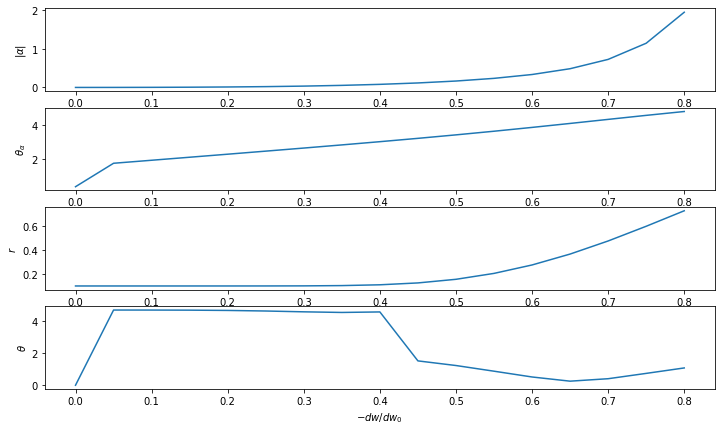

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 7, forward=True)
ax1.plot(dws, alphas2)
ax1.set_ylabel(r'$|\alpha|$')

ax2.plot(dws, alphasT2)
ax2.set_ylabel(r'$\theta_\alpha$')

ax3.plot(dws, xiRs)
ax3.set_ylabel(r'$r$')

ax4.plot(dws, xiTs)
ax4.set_ylabel(r'$\theta$')
ax4.set_xlabel(r'$- dw / dw_0$')
plt.show()

dependence of $\alpha$ and $\xi = r e^\theta$ on the pulse strength $\Delta$w

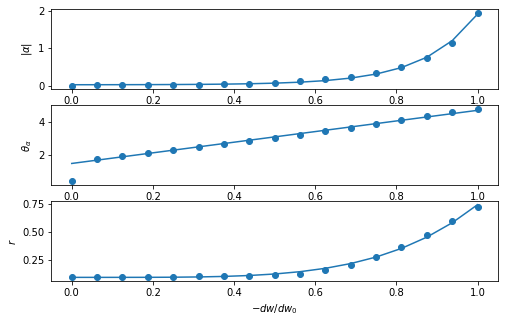

params for alpha: [1.00398439e-03 7.54397529e+00 1.96151900e-02] Errors: [5.05609333e-08 5.18454629e-02 9.83173189e-05]
params for alpha_T: [3.23949262 1.46292285] Errors: [0.00255978 0.00093492]
params for xiR: [0.65237182 4.43040876 0.09222313] Errors: [1.33492776e-04 2.79816714e-02 2.25094338e-05]


In [13]:
# fit a quadratic polynom on the minimum to get a more exact position
def fitFktPol(x, a, b, c):
    return(a*(x**b) + c)

def fitFktExp(x, a, b, c):
    return(a*np.exp(b*x) + c)

def fitFktLin(x, a, b):
    return(a*x+b)

xFit = dws/0.8
paramsA, paramsA_err = optimize.curve_fit(fitFktExp, xFit, alphas2, p0 = [1, 1, 0]) # do the fit for alpha
paramsAT, paramsAT_err = optimize.curve_fit(fitFktLin, xFit[1:], alphasT2[1:], p0 = [0, 0]) # do the fit for alpha, angle in C
paramsX, paramsX_err = optimize.curve_fit(fitFktPol, xFit, xiRs, p0 = [1, 1, 0]) # do the fit for xi

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(8, 5, forward=True)

ax1.scatter(xFit, alphas2)
ax1.plot(xFit, fitFktExp(xFit, paramsA[0], paramsA[1], paramsA[2]))
ax1.set_ylabel(r'$|\alpha|$')

ax2.scatter(xFit, alphasT2)
ax2.plot(xFit, fitFktLin(xFit, paramsAT[0], paramsAT[1]))
ax2.set_ylabel(r'$\theta_\alpha$')

ax3.scatter(xFit, xiRs)
ax3.plot(xFit, fitFktPol(xFit, paramsX[0], paramsX[1], paramsX[2]))
ax3.set_ylabel(r'$r$')
ax3.set_xlabel(r'$- dw / dw_0$')
plt.show()

print("params for alpha:", paramsA, "Errors:", np.diagonal(paramsA_err))
print("params for alpha_T:", paramsAT, "Errors:", np.diagonal(paramsAT_err))
print("params for xiR:", paramsX, "Errors:", np.diagonal(paramsX_err))

Fit of a polynomial or exponential function on the developement of dw <br/>
One finds that for the coherent displacement $\alpha$, an exponential fit of the form $\alpha(dw) = a \cdot exp(b \cdot dw) + c$ gives the best results. For the squeezing parameter $r$ a polynomial Fit of the form $r(dw) = a \cdot (dw)^b + c$ gives the best result.

# Spin-Phonon-Coupling

## set Parameters and compare simulation with theory

In [41]:
def eval_H_spin_phonon_coupling(psi, times, args, options=0, expect=None):
    """evaluates the time evolution of the state psi of internal spin coupled with a harmonic oscillator
    the hamiltonian has an additional term which takes a force proportional to 1/w^2 into account

    parameters:
        psi: initial state for the time evolution (should have dimension n, see below)
            of the form tensor(state1, state2), state1 spin state (2-dim), state2 state harm. osc. (n-dim)
        times: list of times for which the state should be calculated
        args: a dictionary with the following entries:
            n: dimension of the phonon hilbert space (or cutoff dimension for the numerical calculations)
            n_LD: Lamb Dicke parameter
            w0: spin frequency
            wz: harm. osc. frequency
            Omega: Rabi frequency (= coupling strength)
        options: possible options for the solver (mesolve)
        expect: operator, for which the expectation value should be calculated for all t in times (None if the states should be returned)
        n_LD_small: assumes n_LD is close to zero (so that C can be calculated without exp)

    returns:
        a list of states (evolution of psi, one for each t in times)"""
    
    # set variables
    n = args['n']
    n_LD = args['n_LD']
    w0 = args['w0']
    wz = args['wz']
    Omega = args['Omega']
    hbar = args['hbar']

    # prepare operators needed in the Hamiltonian
    # phonon ladder operators
    a = destroy(n)
    ad = a.dag()
    # spin ladder operators
    sUp = 0.5*(sigmax() + 1j*sigmay())
    sDown = 0.5*(sigmax() - 1j*sigmay())
    
    C = (1j*n_LD*(ad + a)).expm() - qeye(n)
    
    # set up the Hamiltonian (taken from Time-Resolved Observation of Thermalization in an Isolated Quantum System)
    # get H_0
    H_sp = [[tensor(sigmaz(), qeye(n)), 'hbar*0.5*w0']] # spin part
    H_sp.append([tensor(qeye(2), ad*a), 'hbar*wz']) # phonon part
    
    # add interaction Hamiltonian - there is still some confusion about the sigmax term
    
    if w0 == 0:
        print("carrier")
        # I need this one for the carrier (wz = 0)
        H_sp.append([tensor(sigmax(), qeye(n)) + tensor(sUp, C) + tensor(sDown, C.dag()), 'hbar*0.5*Omega'])
    else:
        print("first sideband")        
        # and this one for the first red/blue sidebands (wz = +/- w0)
        H_sp.append([tensor(sUp, C) + tensor(sDown, C.dag()), 'hbar*0.5*Omega'])

    # and something else for higher order sidebands

    # calculate the time evolution, allow further options for meolve
    if options==0:
        results = mesolve(H_sp, psi, times, None, expect, args = args)
    else:
        results = mesolve(H_sp, psi, times, None, expect, args = args, options=options)

    return(results)

In [49]:
# setting parameters for this section
n = 20
n_LD = 0.212

# set frequencies
wz = 1.3 * 2*np.pi
w0 = wz
Omega = 0.2 * 2*np.pi
hbar = 1.05457172533628960870683374522*10**-28

# set initial phonon state
# psiPS_P = fock_dm(n, 1) # single fock state
psiPS_P = thermal_dm(n, 1) # thermal state
# psiPS_P = 0.5*(fock_dm(n, 1)+fock_dm(n, 4)) # superposition of fock states
# psiPS_P = coherent_dm(n, 1+1j) # coherent state

n_th = 0.2
alpha = 0.0
xi = np.arcsinh(np.sqrt(1))
psi_P_0 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, n_th)*displace(n, alpha).dag()*squeeze(n, xi).dag()

# set initial state of the composite system
psiPS = tensor(fock_dm(2, 1), psi_P_0)

argsPS = {
    'n': n,
    'n_LD': n_LD,
    'w0': -w0,
    'wz': wz,
    'Omega': Omega,
    'hbar': 1
}

# set projector on the ground/excited state
pg = tensor(Qobj([[1,0],[0,0]]), qeye(n))
pe = tensor(Qobj([[0,0],[0,1]]), qeye(n))

In [53]:
# do the time evolution

opt = Options()
# opt.nsteps = 5000
opt.rhs_reuse = True

t1 = time.time()
# set timesteps (in us) for which the expectation value of pg should be calculated
times = np.linspace(0, 175, 501)
res = eval_H_spin_phonon_coupling(psiPS, times, argsPS, options=opt, expect=pg)
print(round(time.time()-t1), "s")

first sideband
41 s


L2 distance between expectation and time evolution: 0.00043718805022828483


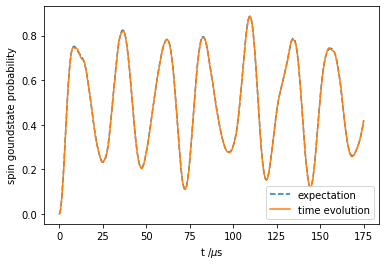

In [54]:
# get the expected ground state probability
probs = evolution_spinState_Analytical(times, 1, 0, psi_P_0, Omega, n_LD, sb = 1)

diff = np.sqrt(np.sum(np.abs(res.expect[0]-probs)**2))/(times[-1] - times[0])
print("L2 distance between expectation and time evolution:", diff)

# plot the expected ground state probability
plt.plot(times, probs, "--", label="expectation")

# plot the calculated (via the time evolution of the spin phonon Hamiltonian) ground state probability
plt.plot(times, res.expect[0], label="time evolution")
plt.xlabel(r't /$\mu$s')
plt.ylabel(r'spin goundstate probability')
plt.legend(loc='lower right')
plt.show()

Occupation probability of the spin ground state (initial in the spin excited state), expected and calculated via the spin phonon coupling Hamiltonian.<br/>
The ground state occupation was calcuated first doing the time evolution of the spin phonon coupling Hamiltonian, second using the analytical formula (83) from LBM+03.<br/>
For similar results, the Lamb Dicke parameter needs to be small. I only get good results for the first sidebands and the carrier.<br/>

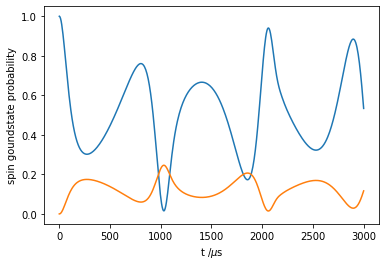

0.72 s


In [8]:
# times
times = np.linspace(0, 3000, 501)

# initial phonon state
psiPS_P = thermal_dm(n, 1)

# number of sideband
n_sb = 2

t1 = time.time()
# get the expected ground state probability
probs1 = evolution_spinState_Analytical(times, 0, 0, psiPS_P, Omega, n_LD, sb = n_sb)
probs2 = evolution_spinState_Analytical(times, 1, 0, psiPS_P, Omega, n_LD, sb = -n_sb)

plt.plot(times, probs1)
plt.plot(times, probs2)
plt.xlabel(r't /$\mu$s')
plt.ylabel(r'spin goundstate probability')
plt.show()
print(np.round(time.time()-t1, 2), "s")

Expected ground state occupation.<br/>
Ground state occupation calculated with formula (83) of LBM+03 with the values from above (simulated ground state occupation), for red and blue n_sb-th sideband.

## check how large the regime of small Lamb Dick parameter is
uses the results from the previous section

In [16]:
def get_diffs__nLD(n_LD):
    # update the lamb dicke parameter
    argsPS['n_LD'] = n_LD
    
    # do the time evolution
    res1 = eval_H_spin_phonon_coupling(psiPS, times, argsPS, expect=pg)
    res2 = eval_H_spin_phonon_coupling(psiPS, times, argsPS, expect=pg, n_LD_small = True)
    
    # get the expected ground state probability
    probs = 0.5
    for i in range(n):
        probs += 0.5*list_Pn[i]*np.cos(RabiTPSR(Omega, n_LD, i, -1)*times)
        
    # calculate the L2 difference between the expected result and the time evolution (with and without n_LD_small = True)
    diff_exp = np.sqrt(np.sum(np.abs(res1.expect[0]-probs)**2))/(times[-1] - times[0])
    diff_LD = np.sqrt(np.sum(np.abs(res1.expect[0]-res2.expect[0])**2))/(times[-1] - times[0])
    
    return([diff_exp, diff_LD])


t1 = time.time()

psiPS_P = thermal_dm(n, 0.1) # thermal state
psiPS = tensor(fock_dm(2, 0), psiPS_P)

listLD = np.linspace(0, 0.3, 13)
if __name__ == "__main__":
    pool = mp.Pool(mp.cpu_count())
    diffList_exp_LD = pool.map(get_diffs__nLD, listLD)
    
diffList_exp = [r[0] for r in diffList_exp_LD]
diffList_LD = [r[1] for r in diffList_exp_LD]
    
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 21.97 s


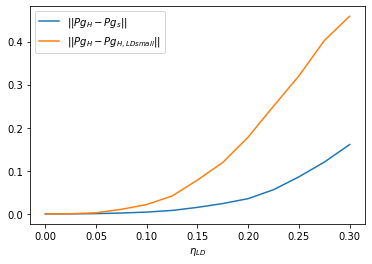

In [17]:
plt.plot(listLD, diffList_exp, label=r'$||Pg_H - Pg_s||$')
plt.plot(listLD, diffList_LD, label=r'$||Pg_H - Pg_{H, LD small}||$')
plt.legend()
plt.xlabel(r'$\eta_{LD}$')
plt.show()

For different Lamb Dicke Parameters $\eta_{LD}$, the L2 distance of the time evolution of the spin ground state population calculated with the spin phonon coupling hamiltonian to:<br/>
1. the expected spin ground state population (which assumes small $\eta_{LD}$)
2. the spin ground state population calculated with an approximation of the spin phonon coupling hamiltonian for small $\eta_{LD}$

are calculated. In the first case, both results are quite close to each other for approximately $\eta_{LD} \in \left[ 0, 0.1\right]$, in the second case for $\eta_{LD} \in \left[ 0, 0.05\right]$.<br/>
You have to take this with a grain of salt, because it depends quite strongly with on the state.

## compare rabi frequencies (carrier vs sideband etc)

17


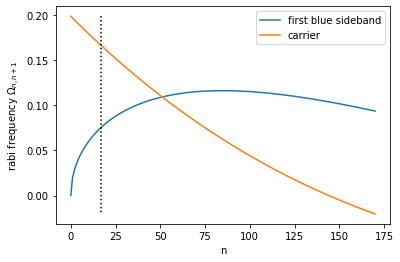

In [10]:
# fock states, for which the Rabi rate is calculated
nList = np.arange(171)

# calculation of the rabi rate for the carrier (2) and the first blue sideband (1)
rList1 = []
rList2 = []
[rList1.append(RabiTPSR(Omega, 0.1, n1, n1-1)) for n1 in nList]
[rList2.append(RabiTPSR(Omega, 0.1, n1, n1)) for n1 in nList]


# check at which point the difference of rabi rates between next neighbours from the carrier gets larger than the blue sideband
n_same = 0
while rList1[n_same+1] - rList1[n_same] > -rList2[n_same+1] + rList2[n_same]:
    n_same += 1
print(n_same)

# plot results
plt.plot(nList, rList1, label="first blue sideband")
plt.plot(nList, rList2, label="carrier")
plt.plot([n_same, n_same],[max(rList2), min(rList2)], 'k:')
plt.legend()
plt.xlabel(r'n')
plt.ylabel(r'rabi frequency $\Omega_{n, n+1}$')
plt.show()

Rabi rates dependant on n for the carrier and the first blue sideband. The larger the derivative, the easier is it to differentiate between different fock states from the time evolution of the state under the spin phonon coupling. The black dotted line indicates where both derivatives are the same.

 my processing time: 0.388 s
 eios processing time: 0.238 s


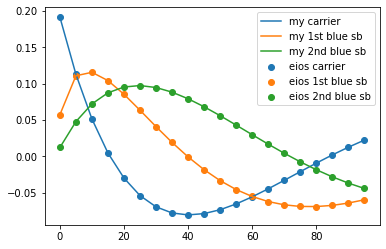

In [13]:
# OmegaOC(n0, n1, Omega0, LDparameter)
n_LD = 0.3

t1 = time.time()
for k in range(1000):
    meins_c = [RabiTPSR(Omega, n_LD, 5*i, 5*i) for i in range(20)]
    meins_b1 = [RabiTPSR(Omega, n_LD, 5*i, 5*i+1) for i in range(20)]
    meins_b2 = [RabiTPSR(Omega, n_LD, 5*i, 5*i+2) for i in range(20)]
print('\r', "my processing time:", np.round((time.time()-t1), 3), "s")

t1 = time.time()
for k in range(1000):
    eios_c = [eios_sb.OmegaOC(5*i, 5*i, Omega, n_LD) for i in range(20)]
    eios_b1 = [eios_sb.OmegaOC(5*i, 5*i+1, Omega, n_LD) for i in range(20)]
    eios_b2 = [eios_sb.OmegaOC(5*i, 5*i+2, Omega, n_LD) for i in range(20)]
print('\r', "eios processing time:", round((time.time()-t1), 3), "s")

nList = [5*i for i in range(20)]
plt.plot(nList, meins_c, label="my carrier")
plt.plot(nList, meins_b1, label="my 1st blue sb")
plt.plot(nList, meins_b2, label="my 2nd blue sb")
plt.scatter(nList, eios_c, label="eios carrier")
plt.scatter(nList, eios_b1, label="eios 1st blue sb")
plt.scatter(nList, eios_b2, label="eios 2nd blue sb")
plt.legend()
plt.show()

Comparison between my (lines) Rabi frequency function and the one from eios (dots), they coincide.

## simulate an experiment using QPN

In [6]:
# setting parameters for this section
n = 20
n_LD = 0.212

# set frequencies
wz = 1.3 * 2*np.pi
w0 = wz
Omega = 0.2 * 2*np.pi


args_RSB = {
    'n': n,
    'n_LD': n_LD,
    'w0': -wz,
    'wz': wz,
    'Omega': Omega,
    'hbar': 1
}

args_BSB = {
    'n': n,
    'n_LD': n_LD,
    'w0': -wz,
    'wz': wz,
    'Omega': Omega,
    'hbar': 1
}

# set projector on the ground state
pg = tensor(Qobj([[1,0],[0,0]]), qeye(n))

n_alpha = 0.9999999999999998 , n_xi = 0.0
 processing time: 0.38 s


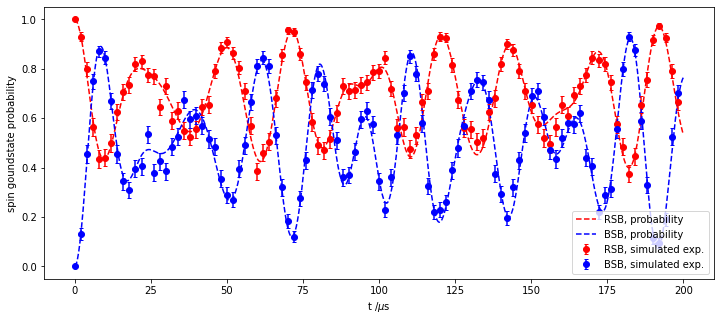

In [217]:
t1 = time.time()

# initial phonon state
n_th = 0.01
alpha = 1/np.sqrt(2)*(1+1j)
xi = np.arcsinh(np.sqrt(0))
psi_P_0 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, n_th)*displace(n, alpha).dag()*squeeze(n, xi).dag()
print("n_alpha =", np.abs(alpha)**2, ", n_xi =", np.sinh(np.abs(xi))**2)

times = np.linspace(0, 200, 1000)
n_points = 100
n_samples = 200
n_skipp = int(round(1000/n_points))

# get the expected ground state probability for red and blue sidebands
list_Pn = np.abs(np.diag(psi_P_0.full()))

probs_RSB = evolution_spinState_Analytical(times, 0, 0, psi_P_0, Omega, n_LD, sb = -1, parallel = True)
probs_BSB = evolution_spinState_Analytical(times, 1, 0, psi_P_0, Omega, n_LD, sb = 1, parallel = True)

opt = Options()
# opt.rhs_reuse = True
# res_RSB = eval_H_spin_phonon_coupling(tensor(fock_dm(2, 0), psi_P_0), times, args_RSB, options=opt, expect=pg)
# res_BSB = eval_H_spin_phonon_coupling(tensor(fock_dm(2, 1), psi_P_0), times, args_BSB, options=opt, expect=pg)
# probs_RSB = res_RSB.expect[0]
# probs_BSB = res_BSB.expect[0]

# simulate QPN
points_RSB, errs_RSB = simulate_QPN(probs_RSB, n_samples, n_skipp = n_skipp)
points_BSB, errs_BSB = simulate_QPN(probs_BSB, n_samples, n_skipp = n_skipp)
times_points = times[::n_skipp]

print('\r', "processing time:", np.round((time.time()-t1), 3), "s")

# plot the expected ground state probability
plt.figure(figsize = (12, 5))
plt.plot(times, probs_RSB, "r--", label="RSB, probability")
plt.plot(times, probs_BSB, "b--", label="BSB, probability")

# plot the simulated datapoints
plt.errorbar(times_points, points_RSB, yerr=errs_RSB, fmt = 'ro', capsize = 2, label="RSB, simulated exp.")
plt.errorbar(times_points, points_BSB, yerr=errs_BSB, fmt = 'bo', capsize = 2, label="BSB, simulated exp.")

plt.xlabel(r't /$\mu$s')
plt.ylabel(r'spin goundstate probability')
plt.legend(loc='lower right')
plt.show()

Spin ground state probability under laser with frequency of the red/blue sideband.<br/>
The dashed line is the theoretically calculated probability, the dots are an simulated experiments (e.g. projecting the wavefunction onto the spin groud state with each measurement).<br/>

The next step is to recover the values for thermal, squeezing, coherent excitement with the fit function from paula (see below), but that doesn't work (the commentation is of course a good help)

Free parameter count 7
migrad started at Wed May 20 16:32:45 2020
migrad finished at Wed May 20 16:33:24 2020


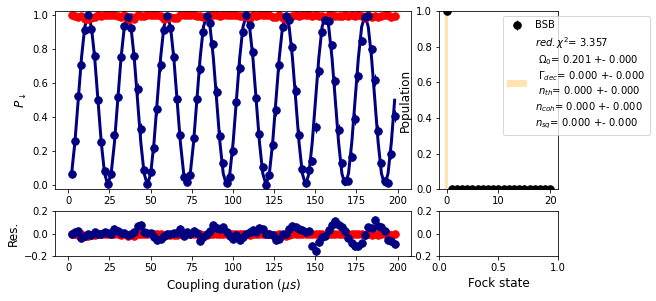

(3.357162077357567,
 ------------------------------------------------------------------
| FCN = 641.2                   |     Ncalls=855 (855 total)     |
| EDM = 3.92E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------,
 ------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  |

In [211]:
# avoiding zeros
errs_RSB = [np.max([err, 0.0000001]) for err in errs_RSB]
errs_BSB = [np.max([err, 0.0000001]) for err in errs_BSB]

# preparing data
redflop = [times_points[1:], np.array(points_RSB[1:]), np.array(errs_RSB[1:])]
blueflop = [times_points[1:], np.array(points_BSB[1:]), np.array(errs_BSB[1:])]

# doing the fit
fitAll = [0,0,0,0,0,0,0]
fitNone = [1,1,1,1,1,0,1]
eios_sb.fit_RSB_BSB_par(redflop, blueflop, n_LD, 20, [0.2,0,0.5,0.5,0.01,0,0], fitAll, ntrot = 1, doplot = True)

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a60445c50>,
       dtype=object))

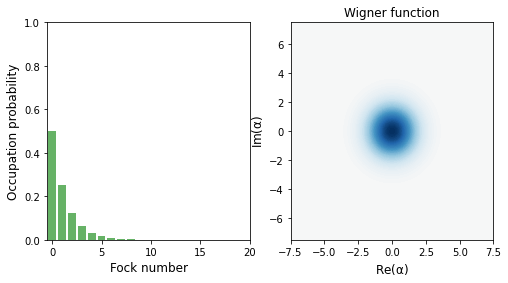

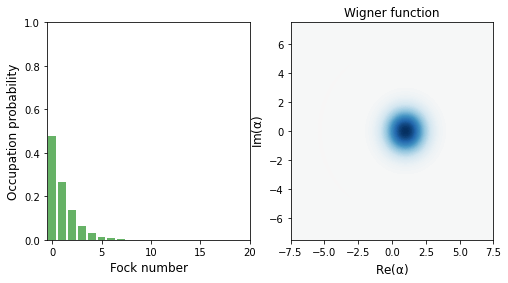

In [212]:
n_th = 1.
alpha = 0j
xi = np.arcsinh(np.sqrt(0))
psi1 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, n_th)*displace(n, alpha).dag()*squeeze(n, xi).dag()
plot_wigner_fock_distribution(psi1)

n_th = 0.5
alpha = np.sqrt(0.5)
xi = np.arcsinh(np.sqrt(0))
psi2 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, n_th)*displace(n, alpha).dag()*squeeze(n, xi).dag()
plot_wigner_fock_distribution(psi2)

This shows, that two fundamentally different states can have very similar fock distributions. The first state is a purely thermal state (with $n_T = 1$), wheras the second state is a displaced thermal state (with $n_{T} = n_\alpha = 0.5$).

In [174]:
# avoiding zeros
errs_RSB = [np.max([err, 0.0000001]) for err in errs_RSB]
errs_BSB = [np.max([err, 0.0000001]) for err in errs_BSB]

# preparing data
redflop = [times_points[1:], np.array(points_RSB[1:]), np.array(errs_RSB[1:])]
blueflop = [times_points[1:], np.array(points_BSB[1:]), np.array(errs_BSB[1:])]

# doing the fit
fitAll = [0,0,0,0,0,0,0]
fitNone = [1,1,1,1,1,1,1]
_,fmin,_,_,_,params,_,_,_ = eios_sb.fit_flop_sb(redflop, blueflop, n_LD, 20, [0.2,0,0.5,0.5,0.01,0,1], fitAll, 1)

Free parameter count 7
migrad started at Wed May 20 16:03:35 2020
migrad finished at Wed May 20 16:04:35 2020


In [175]:
params
fmin['is_valid']

True

In [7]:
# fock_fit = eios_sb.mixedfockdist(n-1, fit_params[4], fit_params[5], fit_params[6], 1)

def diff_fock_state(state, fock, f_ok = True):
    n = state.dims[0][0]
    if f_ok: # only if fit not failed
        # get fock state distribution for fit
        fock = np.array(fock)[:,1]
        # get fock state distribution for original state
        fock_state = np.abs(np.diag(state.full()))
        # calculate the difference between the two
        return(np.sum([(fock[i] - fock_state[i])**2 for i in range(len(fock))]))
    else: # if fit failed
        return(-1)

# fock2 = eios_sb.mixedfockdist(n-1, params[4], params[5], params[6], 1)
# diff_fock_state(psi_P_0, fock2, fmin['is_valid'])

## write and test new fit_flop_sb_fock

In [196]:
# avoiding zeros
errs_RSB = [np.max([err, 0.0000001]) for err in errs_RSB]
errs_BSB = [np.max([err, 0.0000001]) for err in errs_BSB]

# preparing data
redflop = [times_points[1:], np.array(points_RSB[1:]), np.array(errs_RSB[1:])]
blueflop = [times_points[1:], np.array(points_BSB[1:]), np.array(errs_BSB[1:])]

Mr = eios_sb.make_Mat_fit(times_points[1:], -1, 0, 20, n_LD, Omega)
Mb = eios_sb.make_Mat_fit(times_points[1:], 1, 1, 20, n_LD, Omega)

In [204]:
## old function, needs above

t1 = time.time()
res_w = eios_sb.fit_flop_sb_fock(redflop, blueflop, n_LD, 20, [0.2, 0, 0.5, 0.5], [1,1,1,1], np.array(Mr), np.array(Mb))
print('\r', "processing time:", np.round((time.time()-t1), 3), "s")
res_w

Free parameter count 20
migrad started at Wed May 20 16:24:51 2020
migrad finished at Wed May 20 16:24:54 2020
 processing time: 3.585 s


(1.0442343923957491,
 ------------------------------------------------------------------
| FCN = 185.9                   |    Ncalls=2419 (2419 total)    |
| EDM = 2.36E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------,
 ------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  

In [203]:
_,_,_,_,_,_,_,f1,_ = res_wo
_,_,_,_,_,_,_,f2,_ = res_w


print(np.sum([np.abs(f1[i][1] - f2[i][1])**2 for i in range(len(f1))]))
[(f1[i][1] - f2[i][1]) for i in range(len(f1))]

0.13784815770717734


[0.18725820716841807,
 -0.15005653344974623,
 -0.19753549391439612,
 -0.028447241222140124,
 -0.10125014385751364,
 -0.02299477262925607,
 0.07136139174582576,
 0.12921801222995827,
 -0.0012053576917513305,
 -0.0057419743045588065,
 -7.119962900495112e-07,
 -1.4841555722813194e-06,
 6.970175837456831e-08,
 -7.071975562292175e-05,
 -0.005186329453429298,
 -2.496234253737894e-06,
 -6.160971890295353e-07,
 -1.3411668486128364e-06,
 0.06650432804341763,
 0.05815320703918991]

# check how the points should be chosen to fit most efficiently

In [4]:
10/0.2

50.0

In [8]:
# interaction time
Tint = 200

# setting parameters for this section
n = 20
n_LD = 0.212

# set frequencies
wz = 1.3 * 2*np.pi
w0 = wz
Omega = 0.2 * 2*np.pi

# set projector on the ground state
pg = tensor(Qobj([[1,0],[0,0]]), qeye(n))

In [9]:
# prepare states, each with nBar = 1
n_th = 1.5
alpha = (1+1j)
xi = np.arcsinh(np.sqrt(1.5))
psi1 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, n_th)*displace(n, alpha).dag()*squeeze(n, xi).dag()

states = []
states.append(thermal_dm(n, 0.5*n_th))
states.append(thermal_dm(n, n_th))
states.append(displace(n, 0.5*alpha)*fock_dm(n, 0)*displace(n, 0.5*alpha).dag())
states.append(displace(n, alpha)*fock_dm(n, 0)*displace(n, alpha).dag())
states.append(squeeze(n, 0.5*xi)*fock_dm(n, 0)*squeeze(n, 0.5*xi).dag())
states.append(squeeze(n, xi)*fock_dm(n, 0)*squeeze(n, xi).dag())

In [10]:
import gc

In [11]:
# consider overall 12000, 6000, 3000 measurements
t1 = time.time()

n_points_list = [20, 30, 40, 50, 60, 80, 100, 120]
n_samp_list = np.array([600, 400, 300, 240, 200, 150, 120, 100])

n_samp_list = np.append(n_samp_list, n_samp_list/2)
# n_samp_list = np.append(n_samp_list, [n_samp_list/2, n_samp_list/2])

fit_diff = []
fit_diff_std = []
fit_diff_std2 = []
n_fail = []
n_fail_list = np.zeros(len(n_samp_list))
for i in range(len(n_samp_list)):
    t11 = time.time()
    n_samp = int(n_samp_list[i])
    n_points = n_points_list[i % len(n_points_list)]
        
    times = np.linspace(0, Tint, n_points + 1)
    times = times[1:]

    Mr = eios_sb.make_Mat_fit(times, -1, 0, n, n_LD, Omega)
    Mb = eios_sb.make_Mat_fit(times, 1, 1, n, n_LD, Omega)
    
    config_diff = []
    for j in range(len(states)):
        state = states[j]
        
        # get the expected ground state probability for red and blue sidebands
        probs_RSB = evolution_spinState_Analytical(times, 0, 0, state, Omega, n_LD, sb = -1, parallel = True)
        probs_BSB = evolution_spinState_Analytical(times, 1, 0, state, Omega, n_LD, sb = 1, parallel = True)

        # simulate QPN
        points_RSB, errs_RSB = simulate_QPN(probs_RSB, n_samp, n_skipp = 1)
        points_BSB, errs_BSB = simulate_QPN(probs_BSB, n_samp, n_skipp = 1)
        times

        # avoiding zeros
        errs_RSB = [np.max([err, 0.0000001]) for err in errs_RSB]
        errs_BSB = [np.max([err, 0.0000001]) for err in errs_BSB]

        # preparing data
        redflop = [times, np.array(points_RSB), np.array(errs_RSB)]
        blueflop = [times, np.array(points_BSB), np.array(errs_BSB)]

        # do the fit of the fock states
        _,fmin_o,_,_,_,_,_,fock_dist_o,_ = eios_sb.fit_flop_sb_fock(redflop, blueflop, n_LD, 20, [0.2, 0, 0.5, 0.5], [1,1,1,1], np.array(Mr), np.array(Mb), show_Log = False)
        
        # make sure the (rather large) migrad object is not kept in memory
        fit_ok = fmin_o['is_valid']
        fock_dist = fock_dist_o.copy()
        
        # save fock state distribution, but only if the fit converged
        if fit_ok:
            config_diff.append(diff_fock_state(state, fock_dist))
#             print(diff_fock_state(state, fock_dist))
        else:
            n_fail.append([n_samp, n_points, j])
            n_fail_list[i] += 1
            
#         print(fmin['is_valid'])
    # make sure there is a fit that converged
    print(n_samp, n_points, np.round((time.time()-t11), 2), "s")
    if config_diff == []:
        fit_diff.append(-1)
        fit_diff_std.append(0.00001)
        fit_diff_std2.append(0.00001)
    else:
        fit_diff.append(np.mean(config_diff))
        fit_diff_std.append(np.std(config_diff))
        fit_diff_std2.append(np.std(config_diff)/np.sqrt(len(config_diff)))
    gc.collect()
        
print('\r', "processing time:", np.round((time.time()-t1), 2), "s")

600 20 7.01 s
400 30 8.75 s
300 40 90.08 s
240 50 112.38 s
200 60 13.23 s
150 80 150.34 s
120 100 41.05 s
100 120 285.87 s
300 20 8.63 s
200 30 63.68 s
150 40 14.26 s
120 50 13.95 s
100 60 172.29 s
75 80 20.94 s
60 100 219.0 s
50 120 111.22 s
 processing time: 1333.19 s


[[300, 40, 4], [240, 50, 4], [150, 80, 2], [150, 80, 4], [120, 100, 4], [100, 120, 5], [200, 30, 4], [100, 60, 2], [60, 100, 2], [60, 100, 4], [50, 120, 4]]
[0. 0. 1. 1. 0. 2. 1. 1. 0. 1. 0. 0. 1. 0. 2. 1.]


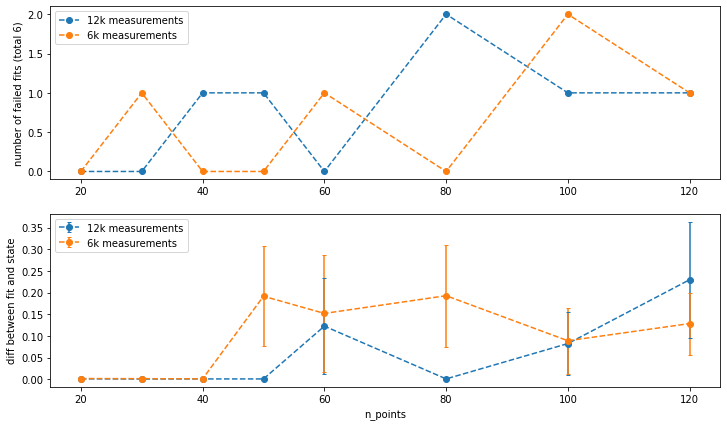

In [29]:
print(n_fail)
print(n_fail_list)

nn = len(n_points_list)
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 7, forward=True)
ax1.plot(n_points_list, n_fail_list[:nn], 'o--', label="12k measurements")
ax1.plot(n_points_list, n_fail_list[nn:2*nn], 'o--', label="6k measurements")
ax1.set_ylabel("number of failed fits (total 6)")
ax1.legend()

ax2.errorbar(n_points_list[:], fit_diff[:nn], yerr=fit_diff_std2[:nn], fmt = 'o--', capsize = 2, label="12k measurements")
ax2.errorbar(n_points_list, fit_diff[nn:2*nn], yerr=fit_diff_std2[nn:2*nn], fmt = 'o--', capsize = 2, label="6k measurements")
# plt.errorbar(n_points_list, fit_diff[2*nn:3*nn], yerr=fit_diff_std[2*nn:3*nn], fmt = 'o--', capsize = 2, label="3k measurements")
ax2.set_xlabel("n_points")
ax2.set_ylabel("diff between fit and state")
ax2.legend()
plt.show()

Goodness of fit and number of failed fits as a function of the number of points taken for the fit.<br/>
The data from the fit comes from the analytically calculated ground state probability (for red- and blue- sidebands), with quantum projection noise applied. In total, 12.000 (6.000) single measurements were simulated, divided into n_points timepoints for each datapoint (=> for 60 n_points, the value and error going into the fit come from an averaging over 200 (100) single measurements at this point).<br/>
One has to keep in mind that the Hilbert space dimension is 20, so the best results are for small number of points with a large number of measurements for each point (I would suggest n_points between $1.5 \cdot \dim(H)$ and $3 \cdot \dim(H)$).<br/>
The computing time is quite ok, but takes a jump if the fit doesn't converge (=> one may consider restricting the number of allowed steps in the migrad function).<br/>
One issue with this computation is that it takes a lot of ram (there are a lot of subprocesses created, but not deleted after the computation).

In [13]:
%store n_fail_list
%store fit_diff
%store fit_diff_std
%store fit_diff_std2

Stored 'n_fail_list' (ndarray)
Stored 'fit_diff' (list)
Stored 'fit_diff_std' (list)
Stored 'fit_diff_std2' (list)


In [14]:
print("ist durchgekommen")

ist durchgekommen
